In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define ordinal encoding for birthweight and gestational age
bw = [
    '<500',
    '500-749',
    '750-999',
    '1000-1249',
    '1250-1499',
    '1500-1749',
     '1750-1999',
    '2000-2499',
    '>2500',
    'UNK'
]
ga = [
    '<=24',
    '25-26',
    '27-28',
    '29-30',
    '31-32',
    '33-34',
    '35-36',
    '>36',
    'UNK'
]

In [ ]:
df = pd.read_csv('cohorts/cohort_t6.csv')

In [239]:
select_labs = [
    'Base Excess',
    # 'pO2',
    # 'pCO2',
    # 'pH',
    # 'Hematocrit',
    # 'White Blood Cells',
    # 'Platelet Count',
]
features = [
    'ga',
    'bw',
    'gender',
    'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    # 'Base Excess_count',
    # 'pO2_count',
    # 'pCO2_count',
    # 'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]
features_to_scale = [
    'Base Excess_valuenum',
    # 'pO2_valuenum',
    # 'pCO2_valuenum',
    # 'pH_valuenum',
    # 'Hematocrit_valuenum',
    # 'White Blood Cells_valuenum',
    # 'Platelet Count_valuenum',
    # 'Base Excess_count',
    # 'pO2_count',
    # 'pCO2_count',
    # 'pH_count',
    # 'Hematocrit_count',
    # 'White Blood Cells_count',
    # 'Platelet Count_count',
]

In [240]:
df['hospital_expire_flag'].value_counts()

hospital_expire_flag
0    1730
1      66
Name: count, dtype: int64

In [241]:
''' 
data_split: returns features (X) and labels (y) for three non-overlapping subsets of the given data frame
'''
def data_split(df, features, train_split, holdout_anchor_year_group):
    # Select specified features
    df = df[['subject_id', 'hospital_expire_flag', 'anchor_year_group'] + features]
    
    # Split dataset into training and testing subsets by time (de-identified temporal proxy is anchor_year_group, holdout on future samples)
    test_df = df[df['anchor_year_group'] == holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    train_df = df[df['anchor_year_group'] != holdout_anchor_year_group].drop('anchor_year_group', axis=1)
    
    # Split data frames into features and labels
    X = train_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    X_test = test_df.drop(['subject_id', 'hospital_expire_flag'], axis=1)
    y = train_df['hospital_expire_flag']
    y_test = test_df['hospital_expire_flag']

    # Split training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1-train_split, random_state=42, stratify=y)

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = data_split(df, features, train_split=0.8, holdout_anchor_year_group='2017 - 2019')

In [138]:
def impute_ga_bw(X):
    X['bw_imp'] = X['bw'].fillna(X.groupby('ga')['bw'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X['ga_imp'] = X['ga'].fillna(X.groupby('bw')['ga'].transform(lambda x: x[x.notna()].mode().iloc[0]))
    X = X.drop(['bw', 'ga'], axis=1)
    return X

In [139]:
def encode_ga_bw(X, bw, ga):
    bw_encoding = {bucket: idx for idx, bucket in enumerate(bw)}
    ga_encoding = {bucket: idx for idx, bucket in enumerate(ga)}
    X['bw_enc'] = X['bw_imp'].map(bw_encoding)
    X['ga_enc'] = X['ga_imp'].map(ga_encoding)
    X = X.drop(['bw_imp', 'ga_imp'], axis=1)
    return X

In [190]:
def encode_gender(X):
    X['gender'] = X['gender'].apply(lambda x: 1 if x == 'M' else 0)
    return X

In [211]:
def impute_lab_values(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_valuenum'
        if lab_col in X: X[lab_col] = X[lab_col].fillna(X[lab_col].mean())
    return X
    
def impute_lab_flags(X, select_labs):
    for lab in select_labs:
        lab_col = f'{lab}_flag'
        if lab_col in X: X[lab_col] = X[lab_col].fillna('normal')
    return X

In [185]:
def fit_scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.fit_transform(X[features_to_scale])

def scale(X, scaler, features_to_scale):
    X[features_to_scale] = scaler.transform(X[features_to_scale])

In [13]:
def smote(X, y, sampling_strategy=0.3):
    smote = SMOTE(sampling_strategy=sampling_strategy) 
    X_upsampled, y_upsampled = smote.fit_resample(X, y)
    return X_upsampled, y_upsampled

In [242]:
scaler = StandardScaler()
X_train = encode_ga_bw(impute_ga_bw(X_train), bw, ga)
X_train = encode_gender(X_train)
X_train = impute_lab_values(X_train, select_labs)
fit_scale(X_train, scaler, features_to_scale)

In [297]:
# X_train, y_train = smote(X_train, y_train, sampling_strategy=0.3)

In [243]:
X_val = encode_ga_bw(impute_ga_bw(X_val), bw, ga)
X_val = encode_gender(X_val)
X_val = impute_lab_values(X_val, select_labs)
scale(X_val, scaler, features_to_scale)

In [216]:
def train_eval(model, X_train, y_train, X_val, y_val, sample_weight=None):
    # Train model
    if sample_weight is None: model.fit(X_train, y_train)
    else: model.fit(X_train, y_train, sample_weight=sample_weight)
    
    # Training metrics
    print("Training:\n")
    y_train_pred = model.predict(X_train)
    y_train_prob = model.predict_proba(X_train)[:,1]
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("AUC:", roc_auc_score(y_train, y_train_prob))
    print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

    # Validation metrics
    print("\nValidation:\n")
    y_val_pred = model.predict(X_val)
    y_val_prob = model.predict_proba(X_val)[:,1]
    print("Accuracy:", accuracy_score(y_val, y_val_pred))
    print("AUC:", roc_auc_score(y_val, y_val_prob))
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

In [244]:
model = LogisticRegression(penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.9677137870855148
AUC: 0.8658881124913733

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1104
           1       0.73      0.19      0.30        42

    accuracy                           0.97      1146
   macro avg       0.85      0.59      0.64      1146
weighted avg       0.96      0.97      0.96      1146


Validation:

Accuracy: 0.9581881533101045
AUC: 0.8435018050541517

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98       277
           1       0.00      0.00      0.00        10

    accuracy                           0.96       287
   macro avg       0.48      0.50      0.49       287
weighted avg       0.93      0.96      0.94       287



In [245]:
model = LogisticRegression(class_weight='balanced', penalty='l2', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.8150087260034904
AUC: 0.8710425293305727

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89      1104
           1       0.14      0.76      0.23        42

    accuracy                           0.82      1146
   macro avg       0.56      0.79      0.56      1146
weighted avg       0.96      0.82      0.87      1146


Validation:

Accuracy: 0.7839721254355401
AUC: 0.8489169675090253

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87       277
           1       0.13      0.90      0.23        10

    accuracy                           0.78       287
   macro avg       0.56      0.84      0.55       287
weighted avg       0.97      0.78      0.85       287



In [246]:
# Logistic regression feature importance
feature_names = X_train.columns
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Absolute_Coefficient'] = abs(feature_importance['Coefficient'])
feature_importance = feature_importance.sort_values(by='Absolute_Coefficient', ascending=False)
print(feature_importance)

                Feature  Coefficient  Absolute_Coefficient
1  Base Excess_valuenum    -0.847925              0.847925
2                bw_enc    -0.279982              0.279982
3                ga_enc    -0.231407              0.231407
0                gender     0.178688              0.178688


In [247]:
model = LogisticRegression(class_weight='balanced', penalty='l1', solver='liblinear')
train_eval(model, X_train, y_train, X_val, y_val)

Training:

Accuracy: 0.8150087260034904
AUC: 0.8709131297446515

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.89      1104
           1       0.14      0.76      0.23        42

    accuracy                           0.82      1146
   macro avg       0.56      0.79      0.56      1146
weighted avg       0.96      0.82      0.87      1146


Validation:

Accuracy: 0.7839721254355401
AUC: 0.8474729241877257

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.78      0.87       277
           1       0.13      0.90      0.23        10

    accuracy                           0.78       287
   macro avg       0.56      0.84      0.55       287
weighted avg       0.97      0.78      0.85       287



In [248]:
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
train_eval(model, X_train, y_train, X_val, y_val, sample_weight)

Training:

Accuracy: 0.9511343804537522
AUC: 0.9920958419599724

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      1104
           1       0.43      1.00      0.60        42

    accuracy                           0.95      1146
   macro avg       0.71      0.97      0.79      1146
weighted avg       0.98      0.95      0.96      1146


Validation:

Accuracy: 0.9128919860627178
AUC: 0.6974729241877257

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.94      0.95       277
           1       0.14      0.30      0.19        10

    accuracy                           0.91       287
   macro avg       0.56      0.62      0.57       287
weighted avg       0.94      0.91      0.93       287



In [249]:
param_grid = {
    'n_estimators': [5, 10, 20, 35, 50, 100],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 3, 5, 10]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Get the best model
model = grid_search.best_estimator_

Best parameters: {'max_depth': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.8678033730974908


In [250]:
print("Training:\n")
y_train_pred = model.predict(X_train)
y_train_prob = model.predict_proba(X_train)[:,1]
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print("AUC:", roc_auc_score(y_train, y_train_prob))
print("\nClassification Report:\n", classification_report(y_train, y_train_pred))

# Validation metrics
print("\nValidation:\n")
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("AUC:", roc_auc_score(y_val, y_val_prob))
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Training:

Accuracy: 0.8603839441535777
AUC: 0.9024219289164941

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92      1104
           1       0.18      0.81      0.30        42

    accuracy                           0.86      1146
   macro avg       0.59      0.84      0.61      1146
weighted avg       0.96      0.86      0.90      1146


Validation:

Accuracy: 0.8222996515679443
AUC: 0.8848375451263538

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90       277
           1       0.13      0.70      0.22        10

    accuracy                           0.82       287
   macro avg       0.56      0.76      0.56       287
weighted avg       0.96      0.82      0.88       287



                Feature  Gini Importance
2                bw_enc         0.385311
3                ga_enc         0.332301
1  Base Excess_valuenum         0.276508
0                gender         0.005881


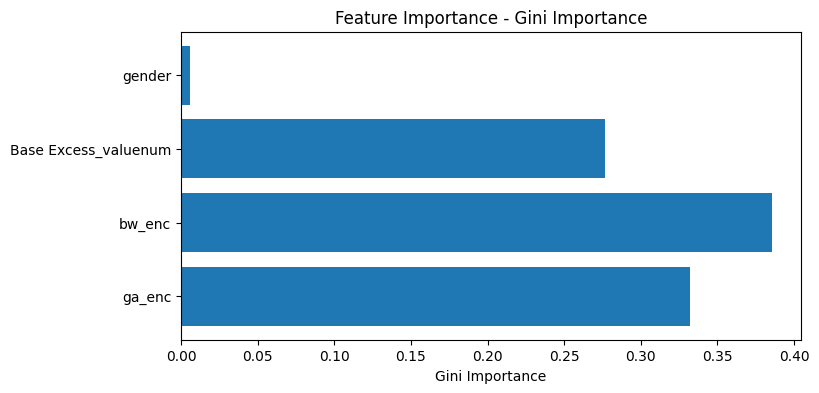

In [251]:
# Random forest feature importance
feature_names = X_train.columns
importances = model.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Gini Importance': importances}).sort_values('Gini Importance', ascending=False)
print(feature_imp_df)

plt.figure(figsize=(8, 4))
plt.barh(feature_names, importances)
plt.xlabel('Gini Importance')
plt.title('Feature Importance - Gini Importance')
plt.gca().invert_yaxis()
plt.show()